In [3]:
import pandas as pd
import numpy as np

In [4]:
# Let's read in one sample for now
df = pd.read_parquet('./A_[1].parquet')

In [5]:
df.head()

,time,y_diff,emf,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,input_excitation_number
0,0.000000,0.040000,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
1,0.002176,0.040013,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
2,0.005176,0.040074,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
3,0.008176,0.040184,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
4,0.011176,0.040341,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0


In [6]:
# Since I've done all the work ahead of time, this should _theoretically_ be just an analysis job...

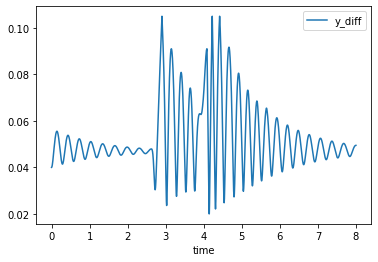

In [7]:
# Let's try plot the simulated graph of a single set of parameters
model_id = 1
df_one_curve = df.query(f'model_id == {model_id}')  # This is unique for this set of data
df_one_curve.plot(x='time', y='y_diff')

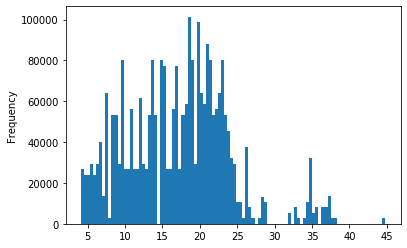

In [8]:
# Nice! Ok, let's try draw some distributions on the metrics
df['y_diff_dtw_distance'].plot(kind='hist', bins=100)

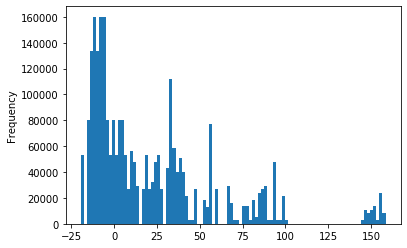

In [9]:
df['rms_perc_diff'].plot(kind='hist', bins=100)

In [10]:
# Let's draw some correlations
df.head()
param_columns = [col for col in df.columns if '.' in col]  # Parameter columns (they happen to contain a dot)
df_no_dupes = df[['y_diff_dtw_distance', 'rms_perc_diff', 'emf_dtw_distance'] + param_columns].drop_duplicates().reset_index(drop=True)

In [11]:
df_no_dupes.head()

,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,load_model.R
0,25.356342,71.913697,429.937399,0.01,0.000000,0.0,30
1,22.537314,77.274114,451.608742,0.01,1.111111,0.0,30
2,23.994554,82.032991,455.136012,0.01,2.222222,0.0,30
3,25.402237,86.632369,450.608010,0.01,3.333333,0.0,30
4,34.904624,99.800001,499.708391,0.01,4.444444,0.0,30


In [12]:
df_no_dupes.describe()

,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,load_model.R
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,17.045719,21.022607,176.344224,0.040000,5.000000,5.000000,30.0
std,6.922650,37.991480,139.134938,0.019158,3.193021,3.193021,0.0
min,4.125895,-19.214414,57.228872,0.010000,0.000000,0.000000,30.0
25%,11.926598,-8.004268,74.602765,0.023333,2.222222,2.222222,30.0
50%,17.866383,6.842957,113.390776,0.040000,5.000000,5.000000,30.0
75%,21.328984,35.876452,257.136477,0.056667,7.777778,7.777778,30.0
max,44.798652,158.475381,628.924793,0.070000,10.000000,10.000000,30.0


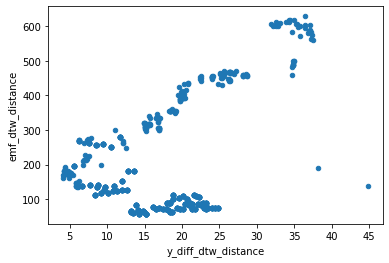

In [13]:
# Are the metrics well-correlated with each other at all?
df_no_dupes.plot(kind='scatter', x='y_diff_dtw_distance', y='emf_dtw_distance')

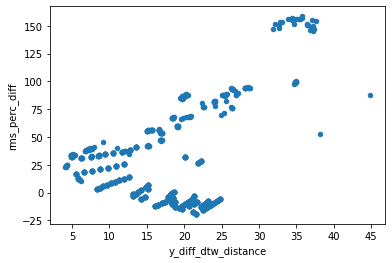

In [14]:
df_no_dupes.plot(kind='scatter', x='y_diff_dtw_distance', y='rms_perc_diff') # <-- the most important one. Really interesting results...

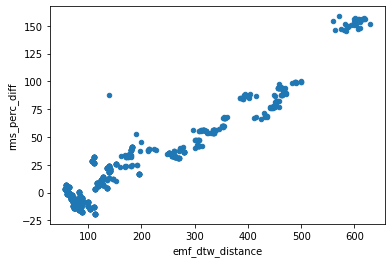

In [15]:
df_no_dupes.plot(kind='scatter', x='emf_dtw_distance', y='rms_perc_diff')

Yes! This is a good sign.

Let's do some statistical comparisons

In [16]:
from scipy import stats

In [24]:
corr, p = stats.pearsonr(df_no_dupes['emf_dtw_distance'], 
                          df_no_dupes['rms_perc_diff'])
print(corr) # <-- actually quite high for the electrical system. This is a good sign.

0.9589553081120902


In [27]:
corr, p = stats.pearsonr(df_no_dupes['y_diff_dtw_distance'],
                         df_no_dupes['rms_perc_diff'])
print(corr)

0.3280382360285876


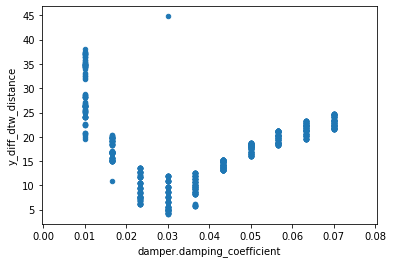

In [28]:
df_no_dupes.plot(kind='scatter', x='damper.damping_coefficient', y='y_diff_dtw_distance')

#### It seems as if the damper coefficient has a _massive_ influence on the DTW distance.

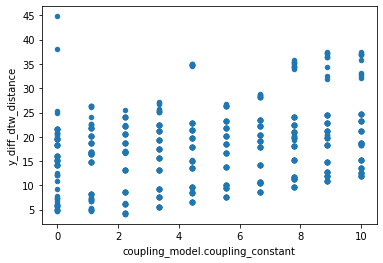

In [29]:
df_no_dupes.plot(kind='scatter', x='coupling_model.coupling_constant', y='y_diff_dtw_distance')

#### Followed by the coupling constant seemingly having some effect, but not _so_ much

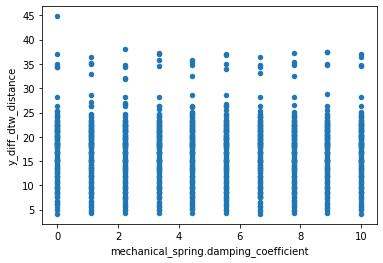

In [30]:
df_no_dupes.plot(kind='scatter', x='mechanical_spring.damping_coefficient', y='y_diff_dtw_distance')

#### The mechanical spring damping coefficient seems to have very _little_ real effect

In [31]:
# Let's try look at all the datasets now... somehow... hope I have enough RAM

In [ ]:
# First preprocess the files to make them vaex-friendly

In [27]:
from glob import glob
import pandas as pd

files = glob('*.parquet')
files.sort()

for f in files:
    df = pd.read_parquet(f)
    df.columns = [col.replace('.', '_') for col in df.columns]
    df.to_parquet(f, engine='pyarrow', compression='brotli')

In [29]:
# Then use vaex to do some processing

In [34]:
from glob import glob
import numpy as np
import vaex


files = glob('A*.parquet') + glob('B*.parquet') + glob('C*.parquet')
files.sort()

grid_cell_id_start = 0
df_list = []

for f in files:
    input_excitation_number = int(f.split('_')[1].split('.')[0].lstrip('[').rstrip(']'))
    device_id = f.split('_')[0]  # A, B or C
    
    df = vaex.open(f)
    df['device_id'] = np.array([device_id]*len(df))
    df['input_excitation_number'] = np.full(len(df), input_excitation_number)
    df['grid_cell_id'] = df['grid_cell_id'] + grid_cell_id_start
    grid_cell_id_start += len(df['grid_cell_id'].unique())
        
    df_list.append(df)

# concat
df_big = df_list[0]
for df in df_list[1:]:
    df_big = df_big.concat(df)

In [35]:
df_big.export_parquet('big_data.parquet')

In [1]:
import dask.dataframe as dd
df = dd.read_parquet('big_data.parquet')

In [2]:
df = df[[col for col in df.columns if col not in ['emf', 'time', 'y_diff']]]
df = df.drop_duplicates()
df.to_parquet('no_curves.parquet')

# Analysis section (split to new Notebook later)

In [2]:
import vaex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [82]:
pwd

'/home/michael/Nextcloud/PhD/Python/unified_model/experiments'

In [3]:
df2 = pd.read_parquet('no_curves.parquet')
df2.head()

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper_damping_coefficient,coupling_model_coupling_constant,mechanical_spring_damping_coefficient,coil_resistance,load_model_R,input_excitation_number,device_id,grid_cell_id
index,,,,,,,,,,,,
0,0,25.356342,75.366695,293.568028,0.01,0.000000,0.0,12.5,30,1,A,0.0
2679,1,22.537314,81.211565,318.222577,0.01,1.111111,0.0,12.5,30,1,A,1.0
5359,2,23.994554,85.854160,311.081156,0.01,2.222222,0.0,12.5,30,1,A,2.0
8039,3,25.402237,90.508289,321.990476,0.01,3.333333,0.0,12.5,30,1,A,3.0
10714,4,34.904624,103.861099,358.224630,0.01,4.444444,0.0,12.5,30,1,A,4.0


In [4]:
cut_off = (1-0.9973)/2
cut_off*100
upper_bound = df2['rms_perc_diff'].quantile(0.9973+cut_off)
lower_bound = df2['rms_perc_diff'].quantile(1-(0.9973+cut_off))
print(lower_bound, upper_bound)

-26.80770290476265 216.58154243543237


In [5]:
df2_filtered = df2.query(f'{lower_bound} < rms_perc_diff < {upper_bound}')
len(df2_filtered)

INFO:MainThread:numexpr.utils:NumExpr defaulting to 4 threads.


14948

In [6]:
df_scores = df2_filtered.groupby('model_id').agg({
    'y_diff_dtw_distance': 'mean',
    'rms_perc_diff': 'mean',
    'emf_dtw_distance': 'mean'
})
df_scores['rms_perc_diff_abs'] = np.abs(df_scores['rms_perc_diff'])
df_scores = df_scores.reset_index()
df_scores.head()

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,rms_perc_diff_abs
0,0,17.510877,55.621991,269.361764,55.621991
1,1,18.488233,60.362832,278.259941,60.362832
2,2,18.961750,69.312704,303.304399,69.312704
3,3,19.520972,78.429270,336.033614,78.429270
4,4,21.185323,86.846941,344.137856,86.846941


In [7]:
# Let's figure out some selection strategies

# First cost strategy -- single metric
y_diff_dist = df_scores.sort_values(by='y_diff_dtw_distance')['model_id'].values[:10]
emf_dist = df_scores.sort_values(by='emf_dtw_distance')['model_id'].values[:10]
rms_perc_diff = df_scores.sort_values(by='rms_perc_diff_abs')['model_id'].values[:10]

# A "balanced strategy"
# First normalize everything
cols_to_normalize = ['y_diff_dtw_distance', 'emf_dtw_distance', 'rms_perc_diff_abs']
for col in cols_to_normalize:
    df_scores[col+'_norm'] = df_scores[col]/df_scores[col].max()

df_scores['balanced'] = df_scores['y_diff_dtw_distance_norm'] + df_scores['emf_dtw_distance_norm'] + df_scores['rms_perc_diff_abs_norm']
df_scores['dtw_balanced'] = df_scores['y_diff_dtw_distance_norm'] + df_scores['emf_dtw_distance_norm']
df_scores['elec_balanced'] = df_scores['emf_dtw_distance_norm'] + df_scores['rms_perc_diff_abs_norm']
balanced = df_scores.sort_values(by='balanced')['model_id'].values[:10]
dtw_balanced = df_scores.sort_values(by='dtw_balanced')['model_id'].values[:10]
elec_balanced = df_scores.sort_values(by='elec_balanced')['model_id'].values[:10]
    
df_scores.head()

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,rms_perc_diff_abs,y_diff_dtw_distance_norm,emf_dtw_distance_norm,rms_perc_diff_abs_norm,balanced,dtw_balanced,elec_balanced
0,0,17.510877,55.621991,269.361764,55.621991,0.610014,0.601714,0.410387,1.622114,1.211728,1.012101
1,1,18.488233,60.362832,278.259941,60.362832,0.644061,0.621591,0.445365,1.711018,1.265652,1.066956
2,2,18.961750,69.312704,303.304399,69.312704,0.660557,0.677537,0.511399,1.849492,1.338093,1.188935
3,3,19.520972,78.429270,336.033614,78.429270,0.680038,0.750649,0.578662,2.009349,1.430687,1.329311
4,4,21.185323,86.846941,344.137856,86.846941,0.738018,0.768752,0.640769,2.147539,1.506770,1.409521


In [8]:
best_param_sets = {
    r'$\texttt{dtw\_mech}$': y_diff_dist[0],
    r'$\texttt{dtw\_elec}$': emf_dist[0],
    r'$\texttt{rms\_perc\_abs}$': rms_perc_diff[0],
    r'$\texttt{balanced}$': balanced[0],
    r'$\texttt{dtw\_both}$': dtw_balanced[0],
    r'$\texttt{rms\_dtw\_elec}$': elec_balanced[0]
}

df_scores['metric_name'] = 'None'

for name, model_id in best_param_sets.items():
    df_scores.loc[df_scores['model_id'] == model_id, 'metric_name'] = name
    
df_best = df_scores[df_scores['model_id'].isin(best_param_sets.values())]
df_best

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,rms_perc_diff_abs,y_diff_dtw_distance_norm,emf_dtw_distance_norm,rms_perc_diff_abs_norm,balanced,dtw_balanced,elec_balanced,metric_name
361,361,6.800717,19.900901,107.646394,19.900901,0.236912,0.240466,0.146832,0.624209,0.477378,0.387297,$\texttt{dtw\_mech}$
512,512,7.795513,10.329949,80.425912,10.329949,0.271567,0.179659,0.076216,0.527442,0.451226,0.255875,$\texttt{dtw\_both}$
640,640,8.267505,1.222321,78.941085,1.222321,0.288009,0.176343,0.009018,0.473370,0.464352,0.185361,$\texttt{balanced}$
833,833,10.933402,-1.646816,68.928933,1.646816,0.380879,0.153977,0.012150,0.547006,0.534856,0.166127,$\texttt{dtw\_elec}$
834,834,11.379743,0.187612,70.565110,0.187612,0.396428,0.157632,0.001384,0.555444,0.554060,0.159016,$\texttt{rms\_dtw\_elec}$
854,854,11.399073,-0.034359,72.049291,0.034359,0.397101,0.160947,0.000254,0.558302,0.558049,0.161201,$\texttt{rms\_perc\_abs}$


In [9]:
model_id_to_metric_name = {k:v for k, v in zip(df_best['model_id'], df_best['metric_name'])}
model_id_to_metric_name

{361: '$\\texttt{dtw\\_mech}$',
 512: '$\\texttt{dtw\\_both}$',
 640: '$\\texttt{balanced}$',
 833: '$\\texttt{dtw\\_elec}$',
 834: '$\\texttt{rms\\_dtw\\_elec}$',
 854: '$\\texttt{rms\\_perc\\_abs}$'}

In [10]:
df_filtered_scores = df2_filtered[df2_filtered.model_id.isin(df_best['model_id'])]
df_filtered_scores['metric_name'] = df_filtered_scores['model_id'].apply(lambda x: model_id_to_metric_name[x])
df_filtered_scores.head()

df_filtered_scores.columns = [col.replace('_', '.') for col in df_filtered_scores.columns]  # Required to stop Latex from exploding
df_filtered_scores.head()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,model.id,y.diff.dtw.distance,rms.perc.diff,emf.dtw.distance,damper.damping.coefficient,coupling.model.coupling.constant,mechanical.spring.damping.coefficient,coil.resistance,load.model.R,input.excitation.number,device.id,grid.cell.id,metric.name
index,,,,,,,,,,,,,
965157,361,4.875746,34.557976,118.551661,0.030000,1.111111,6.666667,12.5,30,1,A,361.0,$\texttt{dtw\_mech}$
1368130,512,13.136919,-1.771534,71.942579,0.043333,2.222222,1.111111,12.5,30,1,A,512.0,$\texttt{dtw\_both}$
1709634,640,16.072263,-10.610394,106.897357,0.050000,0.000000,4.444444,12.5,30,1,A,640.0,$\texttt{balanced}$
2224568,833,21.134329,-10.103831,84.983559,0.063333,3.333333,3.333333,12.5,30,1,A,833.0,$\texttt{dtw\_elec}$
2227236,834,21.328984,-3.427412,82.333678,0.063333,4.444444,3.333333,12.5,30,1,A,834.0,$\texttt{rms\_dtw\_elec}$


In [105]:
def make_ridge_plot(df, row, distribution_metric, x_axis_label, output_path):
    sns.set(style="white",
            rc={"axes.facecolor": (0, 0, 0, 0),
                'text.usetex': True,
                'text.latex.preamble': r'\usepackage{amsmath}',
                'font.family': 'serif'},
            font_scale=1.7)
    
    g = sns.FacetGrid(df, row=row, hue=row, aspect=15, height=0.8)
    g.map(sns.kdeplot, distribution_metric, shade=True, clip_on=False, alpha=1)
    g.map(sns.kdeplot, distribution_metric, clip_on=False, color='w', lw=2, alpha=1)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .15, model_id_to_metric_name[int(label)], ha='left', va='center', transform=ax.transAxes, color=color)
        
    g.map(label, row)
    
    g.set_titles("")
    g.set_axis_labels(distribution_metric)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.subplots_adjust(hspace=-0.5)
    g.set_axis_labels(x_axis_label) 
    g.savefig(output_path)

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-

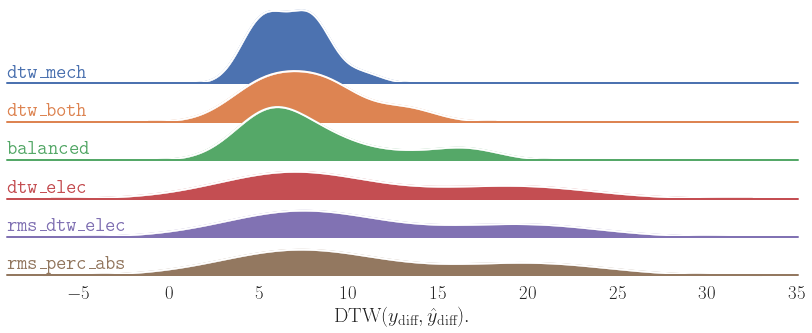

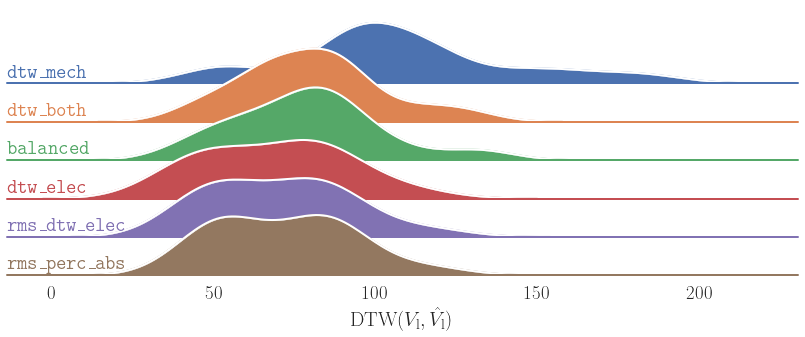

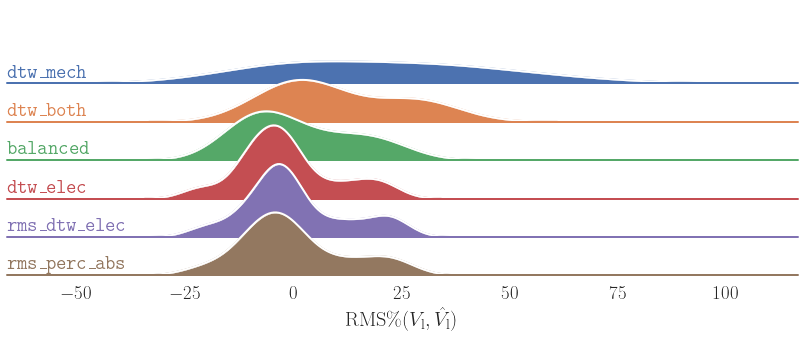

In [106]:
path = '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/'
make_ridge_plot(df_filtered_scores, 'model.id', 'y.diff.dtw.distance', r'$\text{DTW}(y_{\text{diff}},  \hat{y}_{\text{diff}}).$', '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/param_select_dtw_mech.pdf')
make_ridge_plot(df_filtered_scores, 'model.id', 'emf.dtw.distance', r'$\text{DTW}(V_{\text{l}}, \hat{V}_{\text{l}})$', '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/param_select_dtw_elec.pdf')
make_ridge_plot(df_filtered_scores, 'model.id', 'rms.perc.diff', r'$\text{RMS\%}(V_{\text{l}}, \hat{V}_{\text{l}})$', '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/param_select_rms.pdf')

In [187]:
best_param_sets

{'$\\texttt{dtw\\_mech}$': 361,
 '$\\texttt{dtw\\_elec}$': 833,
 '$\\texttt{rms\\_perc\\_abs}$': 854,
 '$\\texttt{balanced}$': 640,
 '$\\texttt{dtw\\_both}$': 512,
 '$\\texttt{rms\\_dtw\\_elec}$': 834}

In [45]:
# Given this, and since we're interested in a balance of quantitative and qualitative matching, we select the `balanced` class
chosen_model_id = best_param_sets['y_diff_dtw']
chosen_model_id

361

In [46]:
# Ok, let's try load the groundtruth
# Let's get some groundtruth in here
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any


class GroundTruthFactory:
    def __init__(self, samples_list, lvp_kwargs, adc_kwargs):
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs
        
        @dataclass
        class MechanicalGroundtruth:
            y_diff: Any
            time: Any
        
        @dataclass
        class ElectricalGroundtruth:
            emf: Any
            time: Any
        
        @dataclass
        class Groundtruth:
            mech: MechanicalGroundtruth
            elec: ElectricalGroundtruth

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)
        self.MechGroundtruth = MechanicalGroundtruth
        self.ElecGroundtruth = ElectricalGroundtruth
        self.Groundtruth = Groundtruth

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return self.MechGroundtruth(y_target,
                                    y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return self.ElecGroundtruth(emf_target,
                                    emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            mech_groundtruth = self._make_mechanical_groundtruth(sample)
            elec_groundtruth = self._make_electrical_groundtruth(sample)

            groundtruths.append(
                self.Groundtruth(mech_groundtruth, elec_groundtruth)
            )

        return groundtruths

# Prepare data
base_groundtruth_path = './data/2019-05-23_C/'
samples = {}
samples['A'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')



/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/utils/utils.py:436: UserWarning: There are a different number of groundtruth files, or some of them could not be found.
  warnings.warn('There are a different number of groundtruth files, or some of them could not be found.')


In [47]:
# Groundtruth

groundtruth = {}
for device in ['A', 'B', 'C']:
    groundtruth_factory = GroundTruthFactory(samples_list=samples[device][:5],  # noqa <-- take the first five groundtruth samples
                                             lvp_kwargs=dict(mm=10,
                                                             seconds_per_frame=1/60,
                                                             pixel_scale=0.154508),
                                             adc_kwargs=dict(voltage_division_ratio=1 / 0.342)  # noqa
    )
    groundtruth[device] = groundtruth_factory.make()

In [48]:
# Let's look at some examples from each

In [49]:
import dask.dataframe as dd 

def get_curve(df_curves_path, model_id, input_excitation_number, device_id):
    #df_curves = vaex.open(df_curves_path)[['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff']]
    df_curves = dd.read_parquet(df_curves_path,
                                columns=['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff'])
    df_temp = df_curves[df_curves['model_id'] == model_id]
    df_temp = df_temp[df_temp['input_excitation_number'] == input_excitation_number]
    df_temp = df_temp[df_temp['device_id'] == device_id].compute()
    del df_curves
    return df_temp

In [50]:
def compare_mech(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target = groundtruth[device_id][input_excitation_number-1].mech.y_diff,  # Referenced to zero
        time_target = groundtruth[device_id][input_excitation_number-1].mech.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance}
    )

    mech_eval.fit(
        y_predict = x['y_diff'].values,
        time_predict = x['time'].values
    )
    print(mech_eval.score())
    mech_eval.poof(figsize=(16,8))
    del x

In [51]:
def compare_elec(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=groundtruth[device_id][input_excitation_number-1].elec.emf,  # Referenced to zero
        time_target=groundtruth[device_id][input_excitation_number-1].elec.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance,
                  'rms_perc_diff': metrics.root_mean_square_percentage_diff},
        clip_threshold=1e-4
    )
    
    elec_eval.fit(
        emf_predict=x['emf'].values,
        time_predict=x['time'].values
    )
    print(elec_eval.score())
    elec_eval.poof(figsize=(16, 8))
    del x

{'dtw_distance': 7.582992407981761}


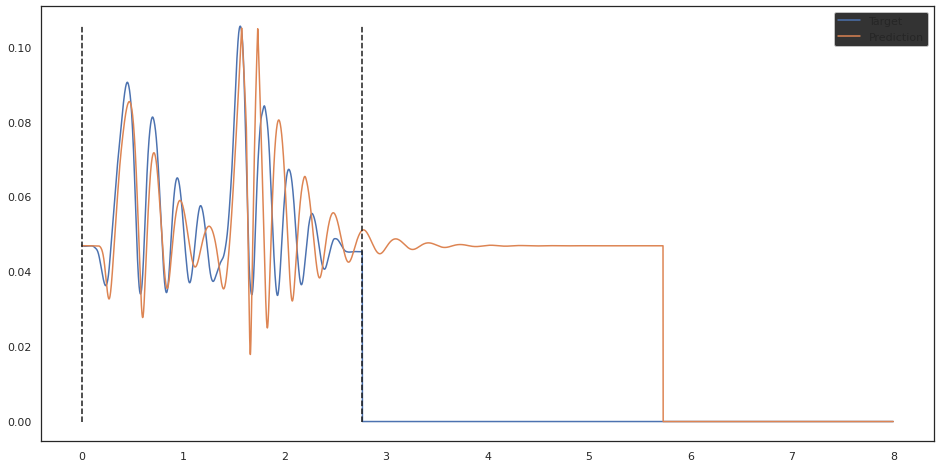

{'dtw_distance': 141.4473117681476, 'rms_perc_diff': 63.88927991459183}


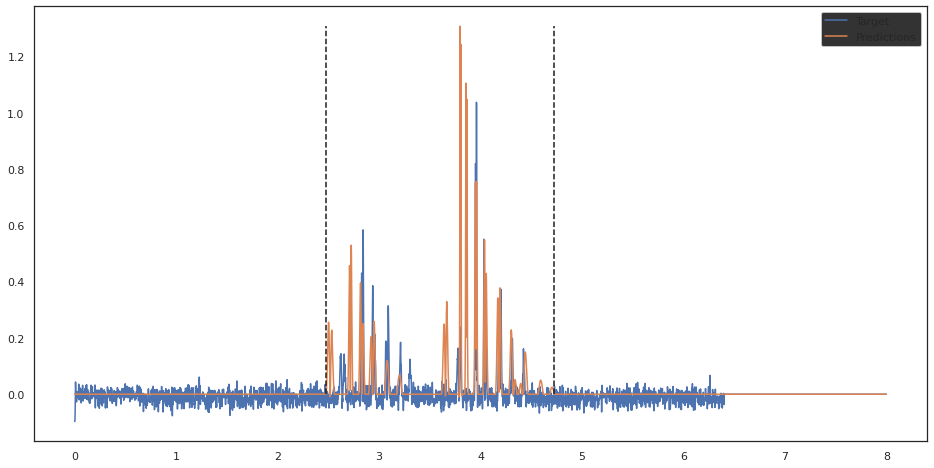

In [54]:
input_ = 4
device = 'A'

compare_mech('big_data.parquet', groundtruth, chosen_model_id, input_, device)
compare_elec('big_data.parquet', groundtruth, chosen_model_id, input_, device)